# BLM example

In [1]:
# Add PyTwoWay to system path (do not run this)
# import sys
# sys.path.append('../../..')

## Import the PyTwoWay package

Make sure to install it using `pip install pytwoway`.

In [2]:
import numpy as np
import bipartitepandas as bpd
import pytwoway as tw
from pytwoway import constraints as cons
from matplotlib import pyplot as plt

## First, check out parameter options

In [3]:
print('----- BLM -----')
tw.blm_params().describe_all()
print('----- Clustering -----')
bpd.cluster_params().describe_all()
print('----- Cleaning -----')
bpd.clean_params().describe_all()
print('----- Simulation -----')
bpd.sim_params().describe_all()

----- BLM -----
KEY: 'nl'
CURRENT VALUE: 6
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=6) Number of worker types.
        
KEY: 'nk'
CURRENT VALUE: None
VALID VALUES: None or one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=None) Number of firm types. None will raise an error when running the estimator.
        
KEY: 'categorical_controls'
CURRENT VALUE: None
VALID VALUES: None or dictionary of type <class 'bipartitepandas.util.ParamsDict'>
DESCRIPTION: 
            (default=None) Dictionary linking column names to instances of tw.categorical_control_params(). Each instance specifies a new categorical control variable and how its starting values should be generated. Run tw.categorical_control_params().describe_all() for descriptions of all valid parameters for simulating each control variable. None is equivalent to {}.
        
KEY: 'continuous_controls'
CURRENT VALUE: None
VALID VALUES: None or dictiona

## Second, set parameter choices

In [4]:
nl = 3 # Number of worker types
nk = 4 # Number of firm types
blm_params = tw.blm_params({
    'nl': nl, 'nk': nk,
    'a1_mu': 0, 'a1_sig': 1.5, 'a2_mu': 0, 'a2_sig': 1.5,
    's1_low': 0.5, 's1_high': 1.5, 's2_low': 0.5, 's2_high': 1.5,
})
cluster_params = bpd.cluster_params({
    'measures': bpd.measures.CDFs(),
    'grouping': bpd.grouping.KMeans(n_clusters=nk),
    'is_sorted': True,
    'copy': False
})
clean_params = bpd.clean_params({
    'drop_returns': 'returners',
    'copy': False
})
sim_params = bpd.sim_params({
    'nl': nl, 'nk': nk,
    'alpha_sig': 1, 'psi_sig': 1, 'w_sig': 0.6,
    'c_sort': 0, 'c_netw': 0, 'c_sig': 1
})

## Extract data (we simulate for the example)

`BipartitePandas` contains the class `SimBipartite` which we use here to simulate a bipartite network. If you have your own data, you can import it during this step. Load it as a `Pandas DataFrame` and then convert it into a `BipartitePandas DataFrame` in the next step.

Note that `l` gives the true worker type and `k` gives the true firm type, while `alpha` gives the true worker effect and `psi` gives the true firm effect. We will save these columns separately.

The BLM estimator uses the firm types computed via clustering, which are saved in columns `g1` and `g2`.

In [5]:
sim_data = bpd.SimBipartite(sim_params).simulate()

## Prepare data

This is exactly how you should prepare real data prior to running the BLM estimator.

- First, we convert the data into a `BipartitePandas DataFrame`

- Second, we clean the data (e.g. drop NaN observations, make sure firm and worker ids are contiguous, etc.)

- Third, we cluster firms by their wage distributions, to generate firm classes (columns `g1` and `g2`)

- Fourth, we collapse the data at the worker-firm spell level (taking mean wage over the spell)

- Fifth, we convert the data into event study format

Further details on `BipartitePandas` can be found in the package documentation, available [here](https://tlamadon.github.io/bipartitepandas/).

In [6]:
# Convert into BipartitePandas DataFrame
sim_data = bpd.BipartiteDataFrame(sim_data)
# Clean and collapse
sim_data = sim_data.clean(clean_params).collapse(is_sorted=True, copy=False)
# Cluster
sim_data = sim_data.cluster(cluster_params)
# Convert to event study format
sim_data = sim_data.to_eventstudy(is_sorted=True, copy=False)

checking required columns and datatypes
sorting rows
dropping NaN observations
generating 'm' column
keeping highest paying job for i-t (worker-year) duplicates (how='max')
dropping workers who leave a firm then return to it (how='returners')
making 'i' ids contiguous
making 'j' ids contiguous
computing largest connected set (how=None)
sorting columns
resetting index


## Separate observed and unobserved data

Some of the simulated data is not observed, so we separate out that data during estimation.

In [7]:
bdf_observed = sim_data.loc[:, ['i', 'j1', 'j2', 'y1', 'y2', 't11', 't12', 't21', 't22', 'g1', 'g2', 'w1', 'w2', 'm']]
bdf_unobserved = sim_data.loc[:, ['alpha1', 'alpha2', 'k1', 'k2', 'l1', 'l2', 'psi1', 'psi2']]

## Separate movers and stayers data

We need to distinguish movers and stayers for the estimator.

In [8]:
movers = sim_data_observed.get_worker_m(is_sorted=True)
jdata = sim_data_observed.loc[movers, :]
sdata = sim_data_observed.loc[~movers, :]

## Check the data

Let's check the cleaned data.

In [9]:
print('Movers data')
display(jdata)
print('Stayers data')
display(sdata)

Movers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
0,0,94,20,-0.336099,-1.735256,0,1,2,3,1,3,2,2,1
1,0,20,172,-1.735256,0.136197,2,3,4,4,3,0,2,1,1
2,1,129,182,-0.349399,0.418880,0,1,2,2,2,0,2,1,1
3,1,182,124,0.418880,-0.668969,2,2,3,4,0,2,1,2,1
4,2,77,171,1.417089,0.724763,0,0,1,4,1,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20214,9924,22,151,-2.198138,-1.157709,2,3,4,4,3,2,2,1,1
20215,9925,55,125,0.395598,0.507435,0,1,2,4,1,2,2,3,1
20216,9926,73,177,-0.925901,0.696322,0,1,2,2,1,0,2,1,1
20217,9926,177,152,0.696322,-0.299671,2,2,3,3,0,2,1,1,1


Stayers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
14,8,69,69,0.180820,0.180820,0,4,0,4,1,1,5,5,0
15,9,111,111,1.183341,1.183341,0,4,0,4,2,2,5,5,0
22,13,66,66,-0.375654,-0.375654,0,4,0,4,1,1,5,5,0
55,29,149,149,0.802797,0.802797,0,4,0,4,2,2,5,5,0
68,35,157,157,-0.497039,-0.497039,0,4,0,4,2,2,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20063,9848,191,191,1.679661,1.679661,0,4,0,4,0,0,5,5,0
20070,9853,186,186,0.848720,0.848720,0,4,0,4,0,0,5,5,0
20126,9881,65,65,0.504421,0.504421,0,4,0,4,1,1,5,5,0
20127,9882,19,19,-0.905983,-0.905983,0,4,0,4,3,3,5,5,0


## Initialize and run BLMEstimator

<div class="alert alert-info">

Note

The `BLMEstimator` class requires data to be formatted as a BipartitePandas DataFrame.

</div>

In [ ]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=jdata, sdata=sdata, n_init=40, n_best=5, ncore=4)

## Check that log-likelihoods are monotonic

Log-likelihoods monotonic (movers): True


Text(0, 0.5, 'Change in log-likelihood')

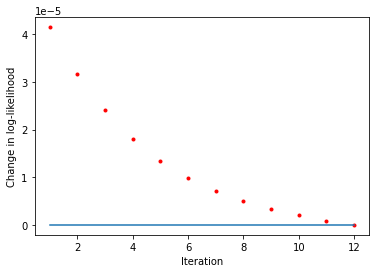

In [11]:
liks1 = blm_fit.model.liks1

print('Log-likelihoods monotonic (movers):', np.min(np.diff(liks1)) >= 0)

x_axis = range(1, len(liks1))
plt.plot(x_axis, np.diff(liks1), '.', label='liks1', color='red')
plt.plot(x_axis, np.zeros(len(liks1) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

Log-likelihoods monotonic (stayers): True


Text(0, 0.5, 'Change in log-likelihood')

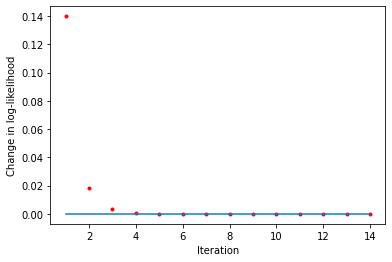

In [12]:
liks0 = blm_fit.model.liks0

print('Log-likelihoods monotonic (stayers):', np.min(np.diff(liks0)) >= 0)

x_axis = range(1, len(liks0))
plt.plot(x_axis, np.diff(liks0), '.', label='liks0', color='red')
plt.plot(x_axis, np.zeros(len(liks0) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

## Now we can investigate the results

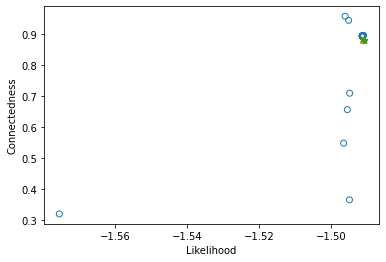

In [13]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

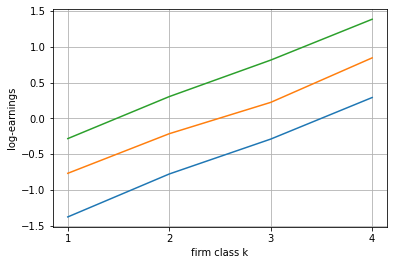

In [14]:
blm_fit.plot_log_earnings()

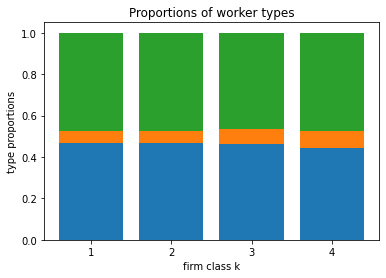

In [15]:
blm_fit.plot_type_proportions()

## Finally, we can compare estimates to the truth

In [16]:
# Compute true parameters
true_A1 = np.expand_dims(sim_data_unobserved.groupby('l1')['alpha1'].mean().to_numpy(), 1) + np.tile(sim_data_unobserved.groupby('k1')['psi1'].mean().to_numpy(), (nl, 1))
true_A2 = np.expand_dims(sim_data_unobserved.groupby('l2')['alpha2'].mean().to_numpy(), 1) + np.tile(sim_data_unobserved.groupby('k2')['psi2'].mean().to_numpy(), (nl, 1))

# Sort estimated parameters (this is because the firm type order generated by clustering is random - this is automatically handled in the built-in plotting functions)
blm_fit.model._sort_matrices(firm_effects=True)

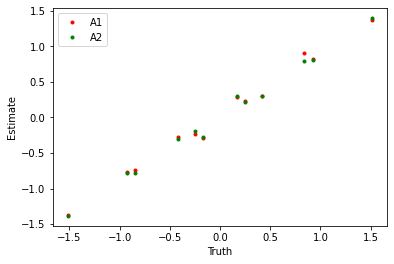

In [17]:
plt.plot(true_A1.flatten(), blm_fit.model.A1.flatten(), '.', label='A1', color='red')
plt.plot(true_A2.flatten(), blm_fit.model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

## Bootstrapped errors

The package contains the class BLMBootstrap, which allows for the construction of bootstrapped error bars.

Instead of the `BLMEstimator` class, we use the `BLMBootstrap` class.

In this example, we use the same simulated data and estimation parameters as in the previous example.

In [ ]:
# Initialize BLM bootstrap estimator
blm_fit = tw.BLMBootstrap(blm_params)
# Fit BLM estimator
blm_fit.fit(
    jdata=jdata, sdata=sdata,
    n_samples=20,
    frac_movers=0.5, frac_stayers=0.5,
    n_init_estimator=40,
    n_best=5,
    ncore=4
)

## Now we can investigate the results

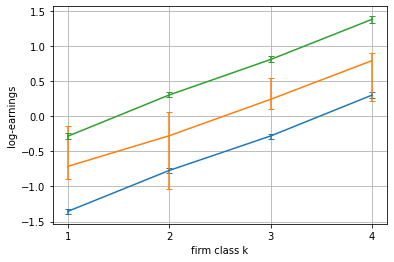

In [19]:
blm_fit.plot_log_earnings()

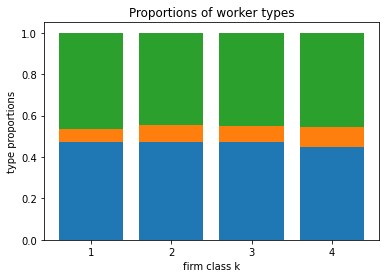

In [20]:
blm_fit.plot_type_proportions()

## Control variables

## Simulating data with controls

The package contains functions to simulate data from the BLM dgp. We use this here to see how to use control variables.

In this example, we simulate a categorical, non-stationary, non-worker-type-interaction control variable. We use a low variance to ensure stability of the estimator.

## Check out simulation parameter options

In [21]:
print('----- Categorical -----')
tw.sim_categorical_control_params().describe_all()
print('----- Continuous -----')
tw.sim_continuous_control_params().describe_all()

----- Categorical -----
KEY: 'n'
CURRENT VALUE: 6
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 2'
DESCRIPTION: 
            (default=6) Number of types for the parameter.
        
KEY: 'a1_mu'
CURRENT VALUE: 1
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
DESCRIPTION: 
            (default=1) Mean of simulated A1_cat (mean of fixed effects in first period).
        
KEY: 'a1_sig'
CURRENT VALUE: 0.5
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
CONSTRAINTS: '>= 0'
DESCRIPTION: 
            (default=0.5) Standard error of simulated A1_cat (mean of fixed effects in first period).
        
KEY: 'a2_mu'
CURRENT VALUE: 1
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
DESCRIPTION: 
            (default=1) Mean of simulated A2_cat (mean of fixed effects in second period).
        
KEY: 'a2_sig'
CURRENT VALUE: 0.5
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
CONSTRAINTS: '>= 0'
DESCRIPTION: 
            (default=0.5) Standard error

## Set simulation parameter choices

In [22]:
n_control = 2 # Number of types for control variable

sim_cat_params = tw.sim_categorical_control_params({
    'n': n_control,
    'stationary_A': False, 'stationary_S': False,
    'worker_type_interaction': False,
    'a1_mu': -0.5, 'a1_sig': 0.25, 'a2_mu': 0.5, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
sim_cts_params = tw.sim_continuous_control_params({
    'stationary_A': True, 'stationary_S': True,
    'worker_type_interaction': True,
    'a1_mu': -0.15, 'a1_sig': 0.05, 'a2_mu': 0.15, 'a2_sig': 0.05,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
blm_sim_params = tw.sim_params({
    'nl': nl, 'nk': nk,
    'a1_mu': -2, 'a1_sig': 0.25, 'a2_mu': 2, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01,
    'categorical_controls': {'cat_control': sim_cat_params},
    'continuous_controls': {'cts_control': sim_cts_params}
})

## Estimating control variables

PyTwoWay allows for categorical and continuous control variables.

### Categorical

To define a categorical control variable, construct an instance of the parameter dictionary `tw.categorical_control_params()`.

Then, inside an instance of `blm_params()`, link the key `'categorical_controls'` to a dictionary linking column names to their associated parameter dictionaries.

### Continuous

To define a continuous control variable, construct an instance of the parameter dictionary `tw.continuous_control_params()`.

Then, inside an instance of `blm_params()`, link the key `'continuous_controls'` to a dictionary linking column names to their associated parameter dictionaries.

### Constraints

Constraints can be specified for control variables. They are set through the `cons_a` and `cons_s` keys for a given control variable's parameter dictionary, except for `NoWorkerTypeInteraction()`. Constraint options are:
- `Linear()` - for a fixed firm type, worker types effects must change linearly
- `Monotonic()` - for a fixed firm type, worker types effects must increase (or decrease) monotonically
- `NoWorkerTypeInteraction()` - for a fixed firm type, worker types effects must all be the same
- `Stationary()` - worker-firm pair effects are the same in all periods
- `StationaryFirmTypeVariation()` - firm type induced variation of worker-firm pair effects is the same in all periods. In particular, this is equivalent to setting A2 = (np.mean(A2, axis=1) + A1.T - np.mean(A1, axis=1)).T.
- `BoundedBelow()` - worker-firm pair effects are bounded below
- `BoundedAbove()` - worker-firm pair effects are bounded above

`NoWorkerTypeInteraction()` is not specified through the `cons_a` and `cons_s` keys. Instead, if you want a control variable to interact with the unobserved worker types, this can be specified by setting `worker_type_interaction=True` in the control variable's parameter dictionary.

<div class="alert alert-warning">

Warning

Please be careful when using particular constraints, such as monotonicity, with control variables. The way they are implemented, when combined with the normalization of certain parameter values to 0, can cause cyclicalities in estimation where parameters are estimated to be monotonic, normalized to be non-monotonic, and continue looping without convergence.

</div>

## Check out estimation parameter options

In [23]:
print('----- Categorical -----')
tw.categorical_control_params().describe_all()
print('----- Continuous -----')
tw.continuous_control_params().describe_all()

----- Categorical -----
KEY: 'n'
CURRENT VALUE: None
VALID VALUES: None or one of type <class 'int'>
CONSTRAINTS: '>= 2'
DESCRIPTION: 
            (default=6) Number of types for the parameter. None will raise an error when running the estimator.
        
KEY: 'a1_mu'
CURRENT VALUE: 1
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
DESCRIPTION: 
            (default=1) Mean of starting values for A1_cat (mean of fixed effects in first period).
        
KEY: 'a1_sig'
CURRENT VALUE: 0.5
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
CONSTRAINTS: '>= 0'
DESCRIPTION: 
            (default=0.5) Standard error of starting values for A1_cat (mean of fixed effects in first period).
        
KEY: 'a2_mu'
CURRENT VALUE: 1
VALID VALUES: one of type (<class 'float'>, <class 'int'>)
DESCRIPTION: 
            (default=1) Mean of starting values for A2_cat (mean of fixed effects in second period).
        
KEY: 'a2_sig'
CURRENT VALUE: 0.5
VALID VALUES: one of type (<class 'floa

## Set estimation parameter choices

In [24]:
cat_params = tw.categorical_control_params({
    'n': n_control,
    'worker_type_interaction': False,
    'cons_a': None, 'cons_s': None,
    'a1_mu': -0.5, 'a1_sig': 0.25, 'a2_mu': 0.5, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
cts_params = tw.continuous_control_params({
    'worker_type_interaction': True,
    'cons_a': cons.Stationary(), 'cons_s': cons.Stationary(),
    'a1_mu': -0.15, 'a1_sig': 0.05, 'a2_mu': 0.15, 'a2_sig': 0.05,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
blm_params = tw.blm_params({
    'nl': nl, 'nk': nk,
    'a1_mu': -2, 'a1_sig': 0.25, 'a2_mu': 2, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01,
    'categorical_controls': {'cat_control': cat_params},
    'continuous_controls': {'cts_control': cts_params}
})

## Simulate data

`sim_data` gives a dictionary where the key `'jdata'` gives simulated mover data and the key `'sdata'` gives simulated stayer data.

`sim_params` gives a dictionary that links each type of control variable to the simulated parameter values for that type.

In [25]:
blm_true = tw.SimBLM(blm_sim_params)
sim_data, sim_params = blm_true.simulate(return_parameters=True)
jdata, sdata = sim_data['jdata'], sim_data['sdata']

In [26]:
print('Movers data')
display(jdata)
print('Stayers data')
display(sdata)
print('Simulated parameter values')
display(sim_params)

Movers data


,i,j1,j2,y1,y2,g1,g2,m,cat_control1,cat_control2,cts_control1,cts_control2,l
0,0,1,0,-2.881183,2.237782,0,0,1,1,0,0.108301,1.186835,2
1,1,0,1,-2.586509,2.275685,0,0,1,0,0,1.322306,0.303418,1
2,2,1,0,-2.633550,2.524240,0,0,1,1,1,-0.768627,-0.261243,0
3,3,0,1,-2.895156,2.498260,0,0,1,1,0,0.210543,-0.885772,2
4,4,0,1,-2.697178,2.322520,0,0,1,1,1,-1.258383,0.564333,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,7,6,-2.078760,2.741095,3,3,1,1,0,-1.266726,-0.068412,1
156,156,7,6,-2.242226,2.059943,3,3,1,1,0,1.385367,0.774606,2
157,157,6,7,-2.631478,2.003347,3,3,1,1,0,-0.268844,0.617792,0
158,158,7,6,-2.442225,2.300372,3,3,1,1,1,2.751899,-0.896864,2


Stayers data


,i,j1,j2,y1,y2,g1,g2,m,cat_control1,cat_control2,cts_control1,cts_control2,l
0,160,1,1,-2.344392,2.559080,0,0,0,0,1,0.154462,-0.386412,0
1,161,1,1,-2.767113,2.331107,0,0,0,1,0,-0.037421,0.016134,1
2,162,0,0,-2.838538,2.807434,0,0,0,1,0,0.243331,-2.443413,1
3,163,1,1,-2.812321,2.601070,0,0,0,1,0,0.160619,-1.425537,1
4,164,0,0,-1.897953,2.234987,0,0,0,0,0,-2.231741,1.234349,0
5,165,1,1,-2.170734,2.417120,0,0,0,0,1,-0.765522,0.334151,0
6,166,0,0,-2.539026,2.269599,0,0,0,1,0,-1.259681,1.007196,0
7,167,0,0,-2.634310,2.371746,0,0,0,1,0,-0.813960,0.512724,0
8,168,0,0,-2.477155,2.582806,0,0,0,0,1,0.818345,-1.241725,1
9,169,0,0,-2.415233,2.481443,0,0,0,0,0,0.476918,-0.816691,1


Simulated parameter values


{'A1': array([[-2.22413079, -2.1017823 , -1.85984209, -2.15792599],
        [-2.23411476, -2.37736357, -1.65930853, -1.77221347],
        [-2.31085405, -1.58741737, -1.99649771, -1.51375145]]),
 'A2': array([[2.08688405, 1.84388791, 1.62963523, 1.74582369],
        [1.94842837, 1.79314557, 2.1136283 , 2.33454424],
        [2.01496561, 2.20917243, 1.90339672, 1.78485606]]),
 'S1': array([[0.00293508, 0.00768226, 0.00161857, 0.0094059 ],
        [0.00776607, 0.00455188, 0.00825925, 0.00552076],
        [0.00418149, 0.00833889, 0.00093743, 0.00701969]]),
 'S2': array([[0.00141546, 0.00599231, 0.00143785, 0.00086827],
        [0.00117988, 0.00550506, 0.00179151, 0.00195794],
        [0.00749887, 0.00732828, 0.00056662, 0.00677319]]),
 'pk1': array([[0.15456883, 0.14725604, 0.69817513],
        [0.30412405, 0.22525405, 0.4706219 ],
        [0.76376471, 0.19342867, 0.04280661],
        [0.10177104, 0.04574561, 0.85248336],
        [0.40066428, 0.18815454, 0.41118118],
        [0.10191985, 0.

## Initialize and run BLMEstimator

In [ ]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=jdata, sdata=sdata, n_init=40, n_best=5, ncore=4)

## Check that log-likelihoods are monotonic

Log-likelihoods monotonic (movers): False


Text(0, 0.5, 'Change in log-likelihood')

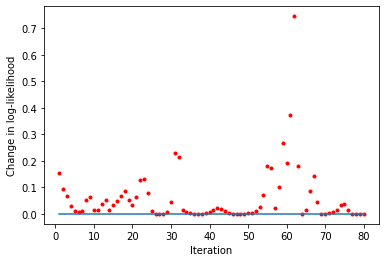

In [28]:
liks1 = blm_fit.model.liks1

print('Log-likelihoods monotonic (movers):', np.min(np.diff(liks1)) >= 0)

x_axis = range(1, len(liks1))
plt.plot(x_axis, np.diff(liks1), '.', label='liks1', color='red')
plt.plot(x_axis, np.zeros(len(liks1) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

Log-likelihoods monotonic (stayers): True


Text(0, 0.5, 'Change in log-likelihood')

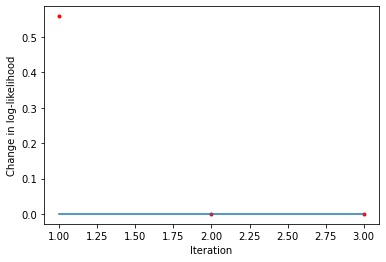

In [29]:
liks0 = blm_fit.model.liks0

print('Log-likelihoods monotonic (stayers):', np.min(np.diff(liks0)) >= 0)

x_axis = range(1, len(liks0))
plt.plot(x_axis, np.diff(liks0), '.', label='liks0', color='red')
plt.plot(x_axis, np.zeros(len(liks0) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

## Now we can investigate the results

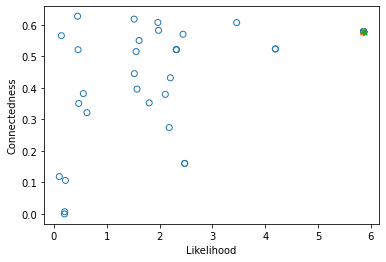

In [30]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

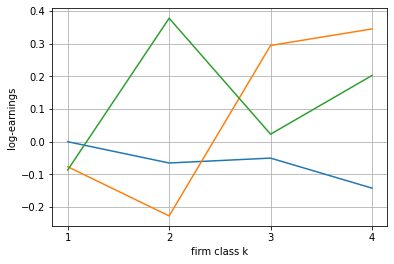

In [31]:
blm_fit.plot_log_earnings()

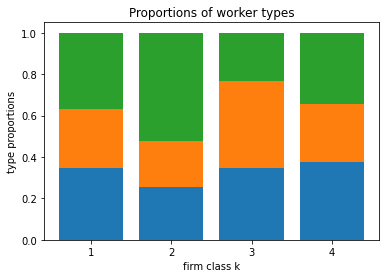

In [32]:
blm_fit.plot_type_proportions()

## Finally, we can compare estimates to the truth

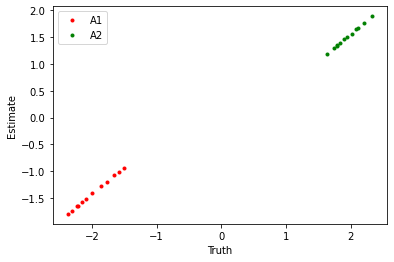

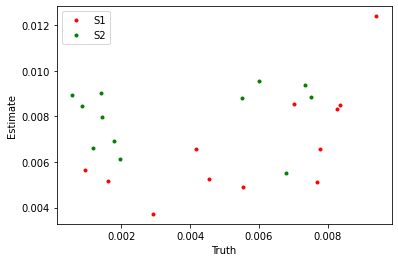

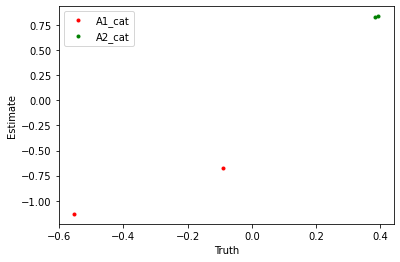

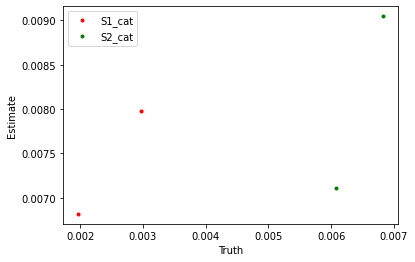

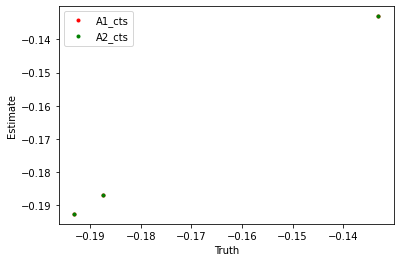

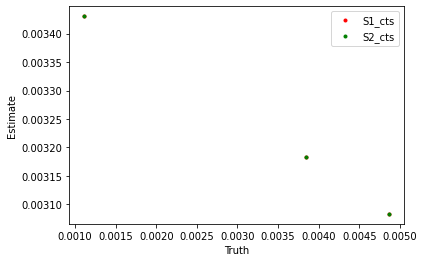

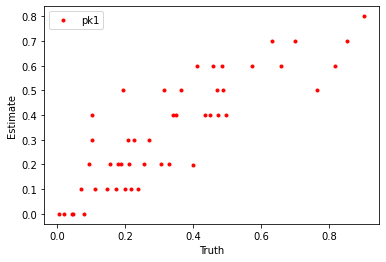

In [33]:
plt.plot(sim_params['A1'].flatten(), blm_fit.model.A1.flatten(), '.', label='A1', color='red')
plt.plot(sim_params['A2'].flatten(), blm_fit.model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1'].flatten(), blm_fit.model.S1.flatten(), '.', label='S1', color='red')
plt.plot(sim_params['S2'].flatten(), blm_fit.model.S2.flatten(), '.', label='S2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['A1_cat']['cat_control'].flatten(), blm_fit.model.A1_cat['cat_control'].flatten(), '.', label='A1_cat', color='red')
plt.plot(sim_params['A2_cat']['cat_control'].flatten(), blm_fit.model.A2_cat['cat_control'].flatten(), '.', label='A2_cat', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1_cat']['cat_control'].flatten(), blm_fit.model.S1_cat['cat_control'].flatten(), '.', label='S1_cat', color='red')
plt.plot(sim_params['S2_cat']['cat_control'].flatten(), blm_fit.model.S2_cat['cat_control'].flatten(), '.', label='S2_cat', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['A1_cts']['cts_control'].flatten(), blm_fit.model.A1_cts['cts_control'].flatten(), '.', label='A1_cts', color='red')
plt.plot(sim_params['A2_cts']['cts_control'].flatten(), blm_fit.model.A2_cts['cts_control'].flatten(), '.', label='A2_cts', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1_cts']['cts_control'].flatten(), blm_fit.model.S1_cts['cts_control'].flatten(), '.', label='S1_cts', color='red')
plt.plot(sim_params['S2_cts']['cts_control'].flatten(), blm_fit.model.S2_cts['cts_control'].flatten(), '.', label='S2_cts', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['pk1'].flatten(), blm_fit.model.pk1.flatten(), '.', label='pk1', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-warning">

Warning

The parameters are identified only up to a constant intercept.

Because of this, to maintain consistency between estimations, PyTwoWay automatically normalizes worker-firm types to have effect 0, depending on the control variables used (normalization only occurs with categorical control variables - for a stationary control variable, only the first period is normalized (if it is non-stationary, both periods are normalized); for a control variable that does not interact with worker types, only the lowest worker type is normalized (if it does interact with worker types, all worker types are normalized)).

If we take the sum over the estimators we see the model performs well.

</div>

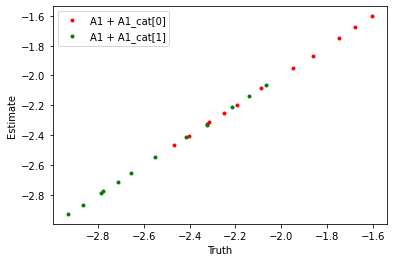

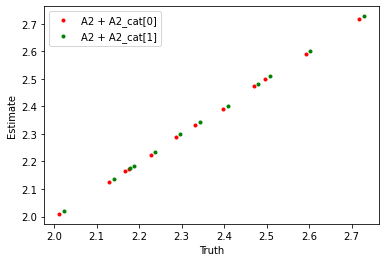

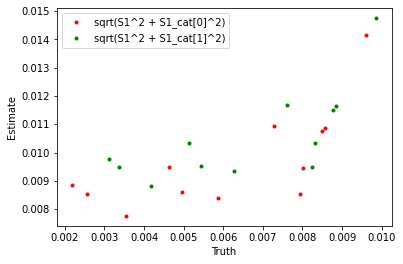

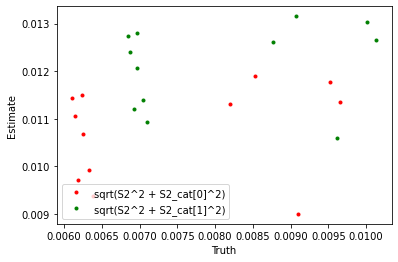

In [34]:
## A1 and A2 ##
plt.plot(
    (sim_params['A1'] + sim_params['A1_cat']['cat_control'][0]).flatten(),
    (blm_fit.model.A1 + blm_fit.model.A1_cat['cat_control'][0]).flatten(),
    '.', label='A1 + A1_cat[0]', color='red'
)
plt.plot(
    (sim_params['A1'] + sim_params['A1_cat']['cat_control'][1]).flatten(),
    (blm_fit.model.A1 + blm_fit.model.A1_cat['cat_control'][1]).flatten(),
    '.', label='A1 + A1_cat[1]', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(
    (sim_params['A2'] + sim_params['A2_cat']['cat_control'][0]).flatten(),
    (blm_fit.model.A2 + blm_fit.model.A2_cat['cat_control'][0]).flatten(),
    '.', label='A2 + A2_cat[0]', color='red'
)
plt.plot(
    (sim_params['A2'] + sim_params['A2_cat']['cat_control'][1]).flatten(),
    (blm_fit.model.A2 + blm_fit.model.A2_cat['cat_control'][1]).flatten(),
    '.', label='A2 + A2_cat[1]', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

## S1 and S2 ##
plt.plot(
    np.sqrt((sim_params['S1'] ** 2 + sim_params['S1_cat']['cat_control'][0] ** 2).flatten()),
    np.sqrt((blm_fit.model.S1 ** 2 + blm_fit.model.S1_cat['cat_control'][0] ** 2).flatten()),
    '.', label='sqrt(S1^2 + S1_cat[0]^2)', color='red'
)
plt.plot(
    np.sqrt((sim_params['S1'] ** 2 + sim_params['S1_cat']['cat_control'][1] ** 2).flatten()),
    np.sqrt((blm_fit.model.S1 ** 2 + blm_fit.model.S1_cat['cat_control'][1] ** 2).flatten()),
    '.', label='sqrt(S1^2 + S1_cat[1]^2)', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(
    np.sqrt((sim_params['S2'] ** 2 + sim_params['S2_cat']['cat_control'][0] ** 2).flatten()),
    np.sqrt((blm_fit.model.S2 ** 2 + blm_fit.model.S2_cat['cat_control'][0] ** 2).flatten()),
    '.', label='sqrt(S2^2 + S2_cat[0]^2)', color='red'
)
plt.plot(
    np.sqrt((sim_params['S2'] ** 2 + sim_params['S2_cat']['cat_control'][1] ** 2).flatten()),
    np.sqrt((blm_fit.model.S2 ** 2 + blm_fit.model.S2_cat['cat_control'][1] ** 2).flatten()),
    '.', label='sqrt(S2^2 + S2_cat[1]^2)', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()